In [ ]:
import pandas as pd
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
sns.set()
!pip install transformers
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('books_def.csv')

In [ ]:
enc = LabelEncoder()
df['genres'] = enc.fit_transform(df.genres)

In [ ]:
label_map = dict(zip(enc.classes_, range(len(enc.classes_))))
label = np.asarray(df.pop('genres'))
text = np.asarray(df['book_desc'])

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.11.0+cu113 Device: cuda [Tesla T4]


In [ ]:
train_set, test_set, train_label, test_label = train_test_split(text, 
                                           label, stratify=label, test_size=0.30, random_state=42)

In [ ]:
sentences_train = ["[CLS] " + s for s in train_set]
sentences_test = ["[CLS] " + s for s in test_set]
labels_train = train_label
labels_test  = test_label

In [ ]:
BERTMODEL = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(BERTMODEL, do_lower_case=True)

In [ ]:
from tqdm import tqdm
tokenized_train = [tokenizer.tokenize(s) for s in tqdm(sentences_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(sentences_test)]

100%|██████████| 10992/10992 [00:40<00:00, 272.00it/s]


In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 256

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
    seq_mask = [float(i>0) for i in seq]
    amasks_train.append(seq_mask)

for seq in ids_test:
    seq_mask = [float(i>0) for i in seq]
    amasks_test.append(seq_mask)

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, labels_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
BATCH_SIZE = 16

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 23081 documents
Validation: 2565 documents
Test: 10992 documents


In [ ]:
model = BertForSequenceClassification.from_pretrained(BERTMODEL,
                                                      num_labels=len(enc.classes_))
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(BERTMODEL))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Pretrained BERT model "bert-base-uncased" loaded


In [ ]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
    model.eval()
    n_correct, n_all = 0, 0
    predicted_labels = list()
    true_labels = list()
    
    for batch in loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,attention_mask=b_input_mask)
            logits = outputs[0]

        logits = logits.detach().cpu().numpy()
        predictions = np.argmax(logits, axis=1)

        labels = b_labels.to('cpu').numpy()
        n_correct += np.sum(predictions == labels)

        true_labels.extend(labels)
        predicted_labels.extend(predictions)
        n_all += len(labels)

    print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
    print('Classification report:')
    print(classification_report(true_labels, predicted_labels,target_names=[x[0] for x in sorted(label_map.items(),key=lambda x:x[1])]))
    #print('Confusion matrix:')
    #cm = confusion_matrix(true_labels, predicted_labels)
    #print(cm)

In [ ]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/23081 (0%)]	Loss: 1.113780
Train Epoch: 1 [3200/23081 (14%)]	Loss: 1.499585
Train Epoch: 1 [6400/23081 (28%)]	Loss: 0.700966
Train Epoch: 1 [9600/23081 (42%)]	Loss: 1.094656
Train Epoch: 1 [12800/23081 (55%)]	Loss: 1.374088
Train Epoch: 1 [16000/23081 (69%)]	Loss: 0.596695
Train Epoch: 1 [19200/23081 (83%)]	Loss: 0.800726
Train Epoch: 1 [22400/23081 (97%)]	Loss: 0.869124

Validation set:
Accuracy: [1851/2565] 0.7216
Classification report:
                 precision    recall  f1-score   support

       Classics       0.74      0.60      0.66       109
        Fantasy       0.68      0.74      0.71       422
        Fiction       0.64      0.69      0.67       496
     Historical       0.68      0.61      0.65       163
        Mystery       0.70      0.58      0.64       141
     Nonfiction       0.86      0.92      0.89       454
        Romance       0.72      0.75      0.74       330
Science Fiction       0.82      0.52      0.63       114
 Sequential Art       0.

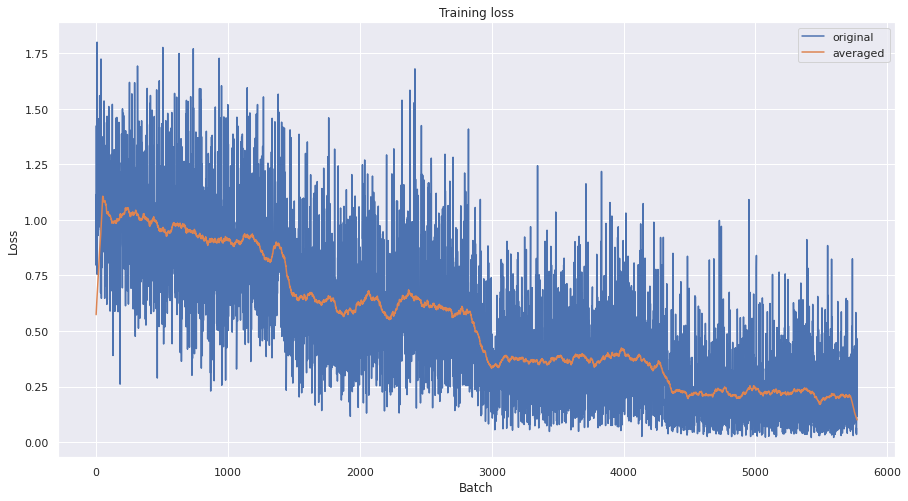

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [8264/10992] 0.7518
Classification report:
                 precision    recall  f1-score   support

       Classics       0.63      0.72      0.67       477
        Fantasy       0.78      0.79      0.78      1891
        Fiction       0.69      0.66      0.68      2134
     Historical       0.65      0.69      0.67       643
        Mystery       0.70      0.68      0.69       612
     Nonfiction       0.91      0.92      0.91      1951
        Romance       0.78      0.77      0.78      1362
Science Fiction       0.79      0.61      0.69       525
 Sequential Art       0.81      0.81      0.81       399
    Young Adult       0.62      0.66      0.64       998

       accuracy                           0.75     10992
      macro avg       0.74      0.73      0.73     10992
   weighted avg       0.75      0.75      0.75     10992

